# Load sold orders data

In [1]:
# import all necessary libraries
import requests
import json
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [3]:
# Time Series
from fbprophet import Prophet as proph
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [4]:
# this is not necessary but helps to run notebook faster
%config Completer.use_jedi = False

In [5]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [6]:
pd.set_option("display.max_columns", 50)

In [7]:
df = pd.read_csv('data/EtsySoldOrderItems2020.csv')

In [8]:
# drop column 'Unnamed: 0'
df.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
df.shape

(26665, 11)

In [10]:
# change column 'Sale Date' to datetime
df['Sale Date'] = pd.to_datetime(df['Sale Date'], infer_datetime_format=True)

In [11]:
df.columns

Index(['Sale Date', 'Item Name', 'Quantity', 'Transaction ID', 'Listing ID',
       'Ship City', 'Ship State', 'Ship Zipcode', 'Ship Country', 'Order ID',
       'Variations'],
      dtype='object')

In [12]:
# rename columns: only use lowercase letters, numbers, and underscores
columns_new = {'Sale Date':'sale_date',
               'Item Name': 'item_name',
               'Quantity': 'quantity',
               'Transaction ID': 'transaction_id',
               'Listing ID': 'listing_id',
               'Ship City': 'ship_city',
               'Ship State': 'ship_state',
               'Ship Zipcode': 'ship_zipcode',
               'Ship Country': 'ship_country',
               'Order ID': 'order_id',
               'Variations': 'variations'}

In [13]:
# rename columns
df.rename(columns=columns_new, inplace=True)

# Load listing id data

In [15]:
listing_data = pd.read_csv('data/listing_id_info.csv')

In [16]:
# drop column 'Unnamed: 0'
listing_data.drop(columns=['Unnamed: 0'], inplace=True)

In [17]:
# set index to listing_id column
# listing_data.set_index('listing_id', inplace=True)

In [18]:
listing_data.shape

(700, 18)

## Listing id data EDA

In [20]:
listing_data.describe()

,listing_id,user_id,category_id,shop_section_id,featured_rank,views,num_favorers,occasion,style,taxonomy_id
count,7.000000e+02,700.0,0.0,5.030000e+02,10.00000,700.000000,700.000000,0.0,0.0,700.000000
mean,6.631329e+08,58888166.0,NaN,2.464366e+07,5.50000,1109.955714,158.025714,NaN,NaN,1602.190000
std,9.736959e+07,0.0,NaN,2.835864e+06,3.02765,5453.481243,313.263169,NaN,NaN,1166.879201
min,5.393977e+08,58888166.0,NaN,2.310936e+07,1.00000,0.000000,0.000000,NaN,NaN,1330.000000
25%,5.856197e+08,58888166.0,NaN,2.310951e+07,3.25000,105.750000,18.750000,NaN,NaN,1330.000000
50%,6.288862e+08,58888166.0,NaN,2.312151e+07,5.50000,296.500000,60.500000,NaN,NaN,1330.000000
75%,7.406108e+08,58888166.0,NaN,2.312152e+07,7.75000,893.000000,159.000000,NaN,NaN,1331.000000
max,9.711306e+08,58888166.0,NaN,3.149817e+07,10.00000,137042.000000,4447.000000,NaN,NaN,6610.000000


In [21]:
listing_data.isna().sum()

listing_id           0
state                0
user_id              0
category_id        700
title                0
description          0
tags                 0
shop_section_id    197
featured_rank      690
views                0
num_favorers         0
occasion           700
style              700
is_customizable      0
has_variations       0
taxonomy_id          0
taxonomy_path        0
main_tag             0
dtype: int64

In [22]:
listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   listing_id       700 non-null    int64  
 1   state            700 non-null    object 
 2   user_id          700 non-null    int64  
 3   category_id      0 non-null      float64
 4   title            700 non-null    object 
 5   description      700 non-null    object 
 6   tags             700 non-null    object 
 7   shop_section_id  503 non-null    float64
 8   featured_rank    10 non-null     float64
 9   views            700 non-null    int64  
 10  num_favorers     700 non-null    int64  
 11  occasion         0 non-null      float64
 12  style            0 non-null      float64
 13  is_customizable  700 non-null    bool   
 14  has_variations   700 non-null    bool   
 15  taxonomy_id      700 non-null    int64  
 16  taxonomy_path    700 non-null    object 
 17  main_tag        

In [23]:
for column in ['state', 'user_id', 'category_id', 'occasion', 'style', 'is_customizable', 'has_variations',
              'taxonomy_id', 'taxonomy_path', 'main_tag']:
    print(listing_data[column].value_counts())

active    700
Name: state, dtype: int64
58888166    700
Name: user_id, dtype: int64
Series([], Name: category_id, dtype: int64)
Series([], Name: occasion, dtype: int64)
Series([], Name: style, dtype: int64)
False    638
True      62
Name: is_customizable, dtype: int64
True     590
False    110
Name: has_variations, dtype: int64
1330    519
1334     73
1332     53
6610     36
1331     17
1349      2
Name: taxonomy_id, dtype: int64
['Paper & Party Supplies', 'Party Supplies']                                            519
['Paper & Party Supplies', 'Party Supplies', 'Party Décor', 'Banners & Signs']           73
['Paper & Party Supplies', 'Party Supplies', 'Party Décor', 'Backdrops & Props']         53
['Craft Supplies & Tools', 'Party & Gifting', 'Party Supplies', 'Balloons']              36
['Paper & Party Supplies', 'Party Supplies', 'Party Décor']                              17
['Paper & Party Supplies', 'Party Supplies', 'Party Favors & Games', 'Party Favors']      2
Name: taxonomy

In [27]:
listing_data['shop_section_id'].value_counts()

23121507.0    100
23109380.0     53
23121521.0     49
23109506.0     45
28453391.0     31
23109442.0     28
23121503.0     26
23121519.0     22
31282498.0     21
23121501.0     21
23109510.0     17
28453385.0     17
28514916.0     15
23109364.0     12
23109394.0     11
30824133.0     11
31498166.0     10
30824113.0      5
30824119.0      4
28475296.0      4
23318583.0      1
Name: shop_section_id, dtype: int64

In [28]:
listing_data['featured_rank'].value_counts()

9.0     1
10.0    1
8.0     1
6.0     1
7.0     1
5.0     1
3.0     1
4.0     1
1.0     1
2.0     1
Name: featured_rank, dtype: int64

In [32]:
# top listings
listing_data[(listing_data['featured_rank'] == 1)|(listing_data['featured_rank'] == 2)|
             (listing_data['featured_rank'] == 3)|(listing_data['featured_rank'] == 4)|
            (listing_data['featured_rank'] == 5)|(listing_data['featured_rank'] == 6)|
            (listing_data['featured_rank'] == 7)|(listing_data['featured_rank'] == 8)|
            (listing_data['featured_rank'] == 9)|(listing_data['featured_rank'] == 10)]

,listing_id,state,user_id,category_id,title,description,tags,shop_section_id,featured_rank,views,num_favorers,occasion,style,is_customizable,has_variations,taxonomy_id,taxonomy_path,main_tag
56,792532131,active,58888166,NaN,Balloon Garland Kit Donut Grow Up Balloons Don...,EASY AND FUN! \n\n-This balloon garland kit co...,"['banner', 'decorations', 'decor', 'donut birt...",28453391.0,2.0,1592,324,NaN,NaN,False,True,6610,"['Craft Supplies & Tools', 'Party & Gifting', ...",sweets
79,776658748,active,58888166,NaN,CACTUS Fiesta Balloon Garland Final Fiesta Bal...,EASY AND FUN! \n\n-This balloon garland kit co...,"['baby shower', 'bridal shower', 'balloon arch...",23121521.0,1.0,1859,383,NaN,NaN,False,True,6610,"['Craft Supplies & Tools', 'Party & Gifting', ...",fiesta
162,779481680,active,58888166,NaN,Tropical Balloon Garland Kit Beach Bach Balloo...,EASY AND FUN! \n\n-This balloon garland kit co...,"['baby shower', 'bridal shower', 'balloon arch...",28475296.0,4.0,1545,269,NaN,NaN,False,True,6610,"['Craft Supplies & Tools', 'Party & Gifting', ...",tropical
260,794235913,active,58888166,NaN,Pastel Butterfly Balloon Garland Kit Peach Pur...,Spring Themed Balloon Garland perfect for your...,"['baby shower', 'bridal shower', 'balloon garl...",28453391.0,3.0,421,69,NaN,NaN,False,True,6610,"['Craft Supplies & Tools', 'Party & Gifting', ...",holidays
296,788603607,active,58888166,NaN,Jungle Balloon Garland Kit Balloon Arch Wild B...,EASY AND FUN! \n\n-This balloon garland kit co...,"['wild one', 'jungle', 'safari', 'baby shower'...",28453385.0,5.0,1642,222,NaN,NaN,False,True,6610,"['Craft Supplies & Tools', 'Party & Gifting', ...",wild
312,912150565,active,58888166,NaN,Winter Onederland Balloon Garland Kit Pink Whi...,This listing is for the *NAME* IS ONE balloons...,"['Balloon Garland', 'Winter', 'Winter Onederla...",23121521.0,7.0,729,49,NaN,NaN,True,True,1330,"['Paper & Party Supplies', 'Party Supplies']",other
443,935499642,active,58888166,NaN,Galentines Day Balloon Garland Kit Valentines ...,SO EASY AND FUN! \n\n- This balloon garland ki...,"['Galentines Day', 'Galentines', 'Galentines D...",NaN,6.0,183,16,NaN,NaN,False,True,6610,"['Craft Supplies & Tools', 'Party & Gifting', ...",holidays
444,564573099,active,58888166,NaN,Galentines Day Party Balloons Valentines Day P...,Letter Balloons are roughly 13.5 inches tall w...,"['balloons', 'galentines day', 'valentines day...",NaN,8.0,1138,216,NaN,NaN,False,True,1332,"['Paper & Party Supplies', 'Party Supplies', '...",holidays
514,895887161,active,58888166,NaN,Winter Onederland Balloon Banner Winter 1st Bi...,LETTER Balloons are roughly 13.5 inches tall w...,"['Banner', 'Winter Onederland', 'Onederland', ...",30824113.0,10.0,247,27,NaN,NaN,True,True,1330,"['Paper & Party Supplies', 'Party Supplies']",other
571,760416372,active,58888166,NaN,Galentines Day Party Decor Galentines Day Ball...,Balloons are roughly 13.5 inches tall when inf...,"['galentines day', 'day decorations', 'galenti...",NaN,9.0,141,29,NaN,NaN,False,True,1330,"['Paper & Party Supplies', 'Party Supplies']",holidays


# Merge sold orders data and listing id data

In [33]:
df.shape

(26665, 11)

In [34]:
combined = pd.merge(df, listing_data, on = 'listing_id', how = 'left')  # how = 'inner' results in 26111 rows × 27 columns

In [36]:
combined.shape  # df has 26665 rows × 11 columns

(26665, 28)

In [37]:
combined.isna().sum()

sale_date              0
item_name              0
quantity               0
transaction_id         0
listing_id             0
ship_city              0
ship_state             0
ship_zipcode           0
ship_country           0
order_id               0
variations          2186
state                571
user_id              571
category_id        26665
title                571
description          571
tags                 571
shop_section_id     3117
featured_rank      26329
views                571
num_favorers         571
occasion           26665
style              26665
is_customizable      571
has_variations       571
taxonomy_id          571
taxonomy_path        571
main_tag             571
dtype: int64

In [38]:
# save combined dataframe as a csv file
combined.to_csv('data/combined.csv')

# Combined table EDA

There were 26,665 transactions in 2020. Let's review these transactions.

In [39]:
# Set styles of visualizations
sns.set_style('darkgrid')
sns.set_context('poster')

## Top Listing IDs

In [40]:
top_listing_id = combined.groupby('listing_id').quantity.aggregate('sum').sort_values(ascending=False)

In [41]:
len(top_listing_id)

681

Out of 700 listing IDs, 681 listing IDs were ordered in 2020.

In [42]:
# top 10 listing IDs ordered in 2020
top_listing_id[:10]

listing_id
761510402    991
614616642    864
614617726    676
781142924    580
736323397    566
586512074    511
588570903    508
614618212    488
615026944    420
795021375    371
Name: quantity, dtype: int64

In [43]:
# bottom 10 listing IDs ordered in 2020
top_listing_id[-10:]

listing_id
717859504    1
799504471    1
849787277    1
843446730    1
840254532    1
839623671    1
780411854    1
835878334    1
833607875    1
597783442    1
Name: quantity, dtype: int64

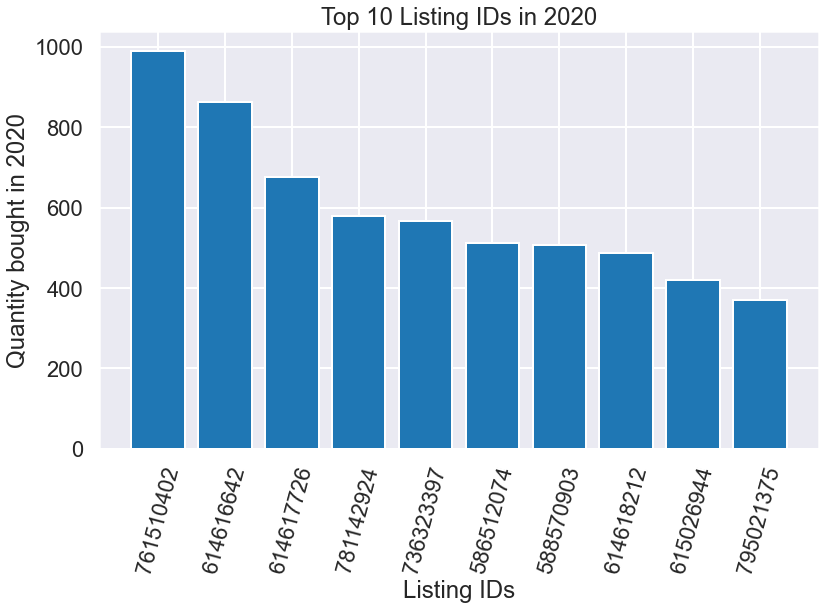

In [44]:
fig, ax = plt.subplots(figsize=(12,9))
ax.bar(['761510402', '614616642', '614617726', '781142924', '736323397', '586512074',
            '588570903', '614618212', '615026944', '795021375'], top_listing_id[:10])
ax.set_title('Top 10 Listing IDs in 2020')
ax.set_xlabel('Listing IDs')
ax.set_ylabel('Quantity bought in 2020')
plt.xticks(rotation= 75)
fig.tight_layout();

## Top Item Names

In [45]:
top_listing_title = combined.groupby('item_name').quantity.aggregate('sum').sort_values(ascending=False)

In [46]:
# top 10 item names ordered in 2020
top_listing_title[:10]

item_name
Bachelorette Party Decor Bach Party Decorations Bachelorette Decor Bachelorette Decorations Bachelorette Balloons Boujee Bachelorette Decor     1557
Bach and Boujee Bachelorette Party Decor Bach Party Decorations Bride and Boujee Banner Bachelorette Decor Bach Balloons Balloon Banner          929
Quarantine Queen Quarantined Birthday Balloons Social Distancing Birthday Gift 30th Birthday Decorations 21st 60th Birthday Self Isolation       683
So Happy Im Thirty Balloons I'm Thirty 30th Birthday Balloons 30th Birthday Decor 30th Birthday Decorations Shit Im 30 Thirty Years Banner       676
Custom Happy Birthday Balloon Banner Birthday Decorations 21st Birthday Decor 30th Birthday Party Decorations 22nd 23rd 24th 25th 26th 27th      511
Custom Balloon Letters Balloon Phrase Gold Letter Balloons Custom Balloon Banner Balloon Letters                                                 508
So Happy Im Thirty Balloons 30th Birthday Balloons 30th Birthday Decor for Him 30th Birthday Dec

## Top Ship States

In [47]:
top_ship_state = combined.groupby('ship_state').quantity.aggregate('sum').sort_values(ascending=False)

In [48]:
len(top_ship_state)

60

Ship states include US territories.

In [49]:
top_ship_state[:10]

ship_state
CA    3293
TX    2659
NY    1898
FL    1634
IL    1204
PA    1190
NJ    1173
GA     949
NC     908
OH     874
Name: quantity, dtype: int64

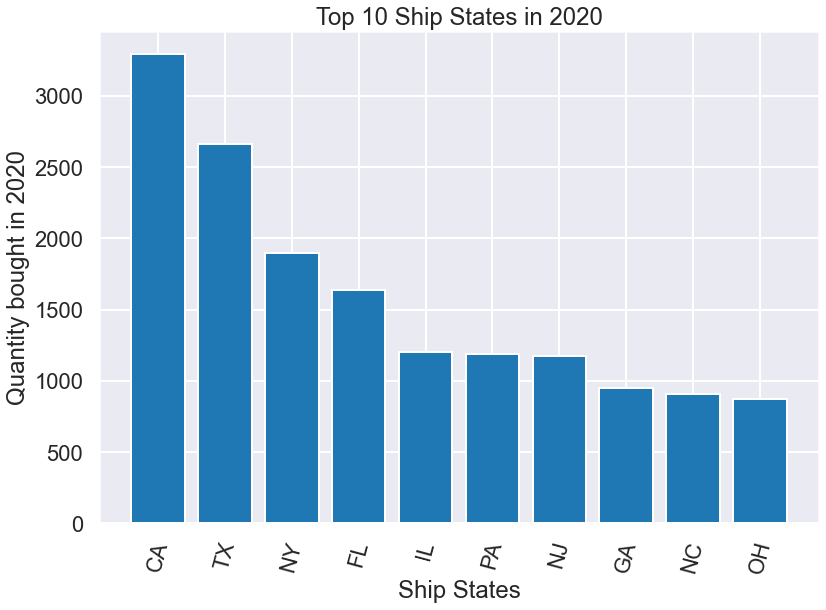

In [50]:
fig, ax = plt.subplots(figsize=(12,9))
ax.bar(top_ship_state.index[:10], top_ship_state[:10])
ax.set_title('Top 10 Ship States in 2020')
ax.set_xlabel('Ship States')
ax.set_ylabel('Quantity bought in 2020')
plt.xticks(rotation= 75)
fig.tight_layout();

## Top Categories

In [51]:
top_tags = combined.groupby('main_tag').quantity.aggregate('sum').sort_values(ascending=False)

In [52]:
len(top_tags)

12

In [53]:
top_tags

main_tag
other         3978
adult_bday    3818
boujee        3399
holidays      2492
fiesta        2148
tropical      2126
quarantine    2068
sweets        1987
engagement    1857
wild          1542
graduation     838
western        706
Name: quantity, dtype: int64

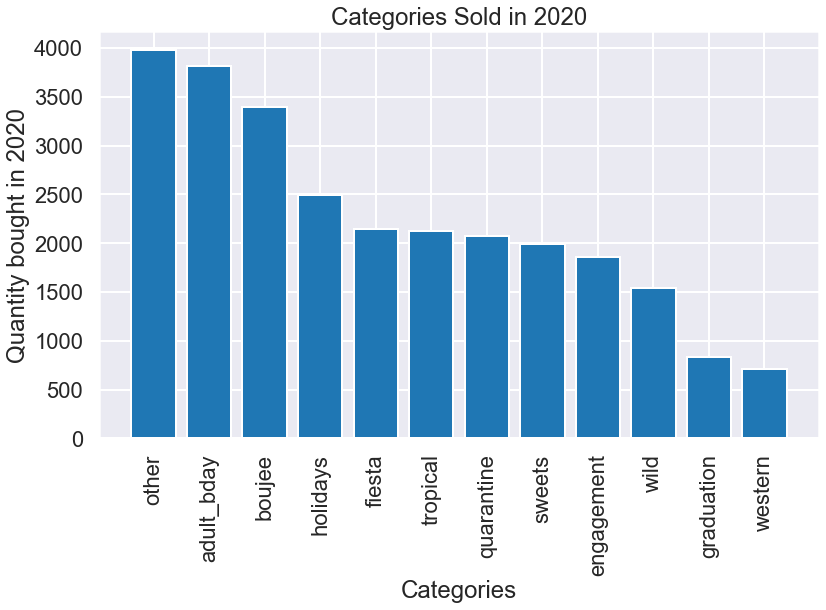

In [54]:
fig, ax = plt.subplots(figsize=(12,9))
ax.bar(top_tags.index, top_tags)
ax.set_title('Categories Sold in 2020')
ax.set_xlabel('Categories')
ax.set_ylabel('Quantity bought in 2020')
plt.xticks(rotation= 90)
fig.tight_layout();

## Review Categories by Listings

In [55]:
top_tag_listing = combined.groupby(['main_tag', 'listing_id']).quantity.aggregate('sum').sort_values(ascending=False)

In [56]:
len(top_tag_listing)

607

In [57]:
top_tag_listing[:20]

main_tag    listing_id
boujee      761510402     991
            614616642     864
adult_bday  614617726     676
quarantine  781142924     580
boujee      736323397     566
adult_bday  586512074     511
other       588570903     508
adult_bday  614618212     488
engagement  615026944     420
quarantine  795021375     371
adult_bday  600298263     364
tropical    602285896     359
engagement  654748586     356
quarantine  781075054     354
sweets      573703826     323
wild        587307359     288
graduation  600353345     280
other       600252567     258
sweets      794228533     251
other       571190017     247
Name: quantity, dtype: int64

# Time series EDA

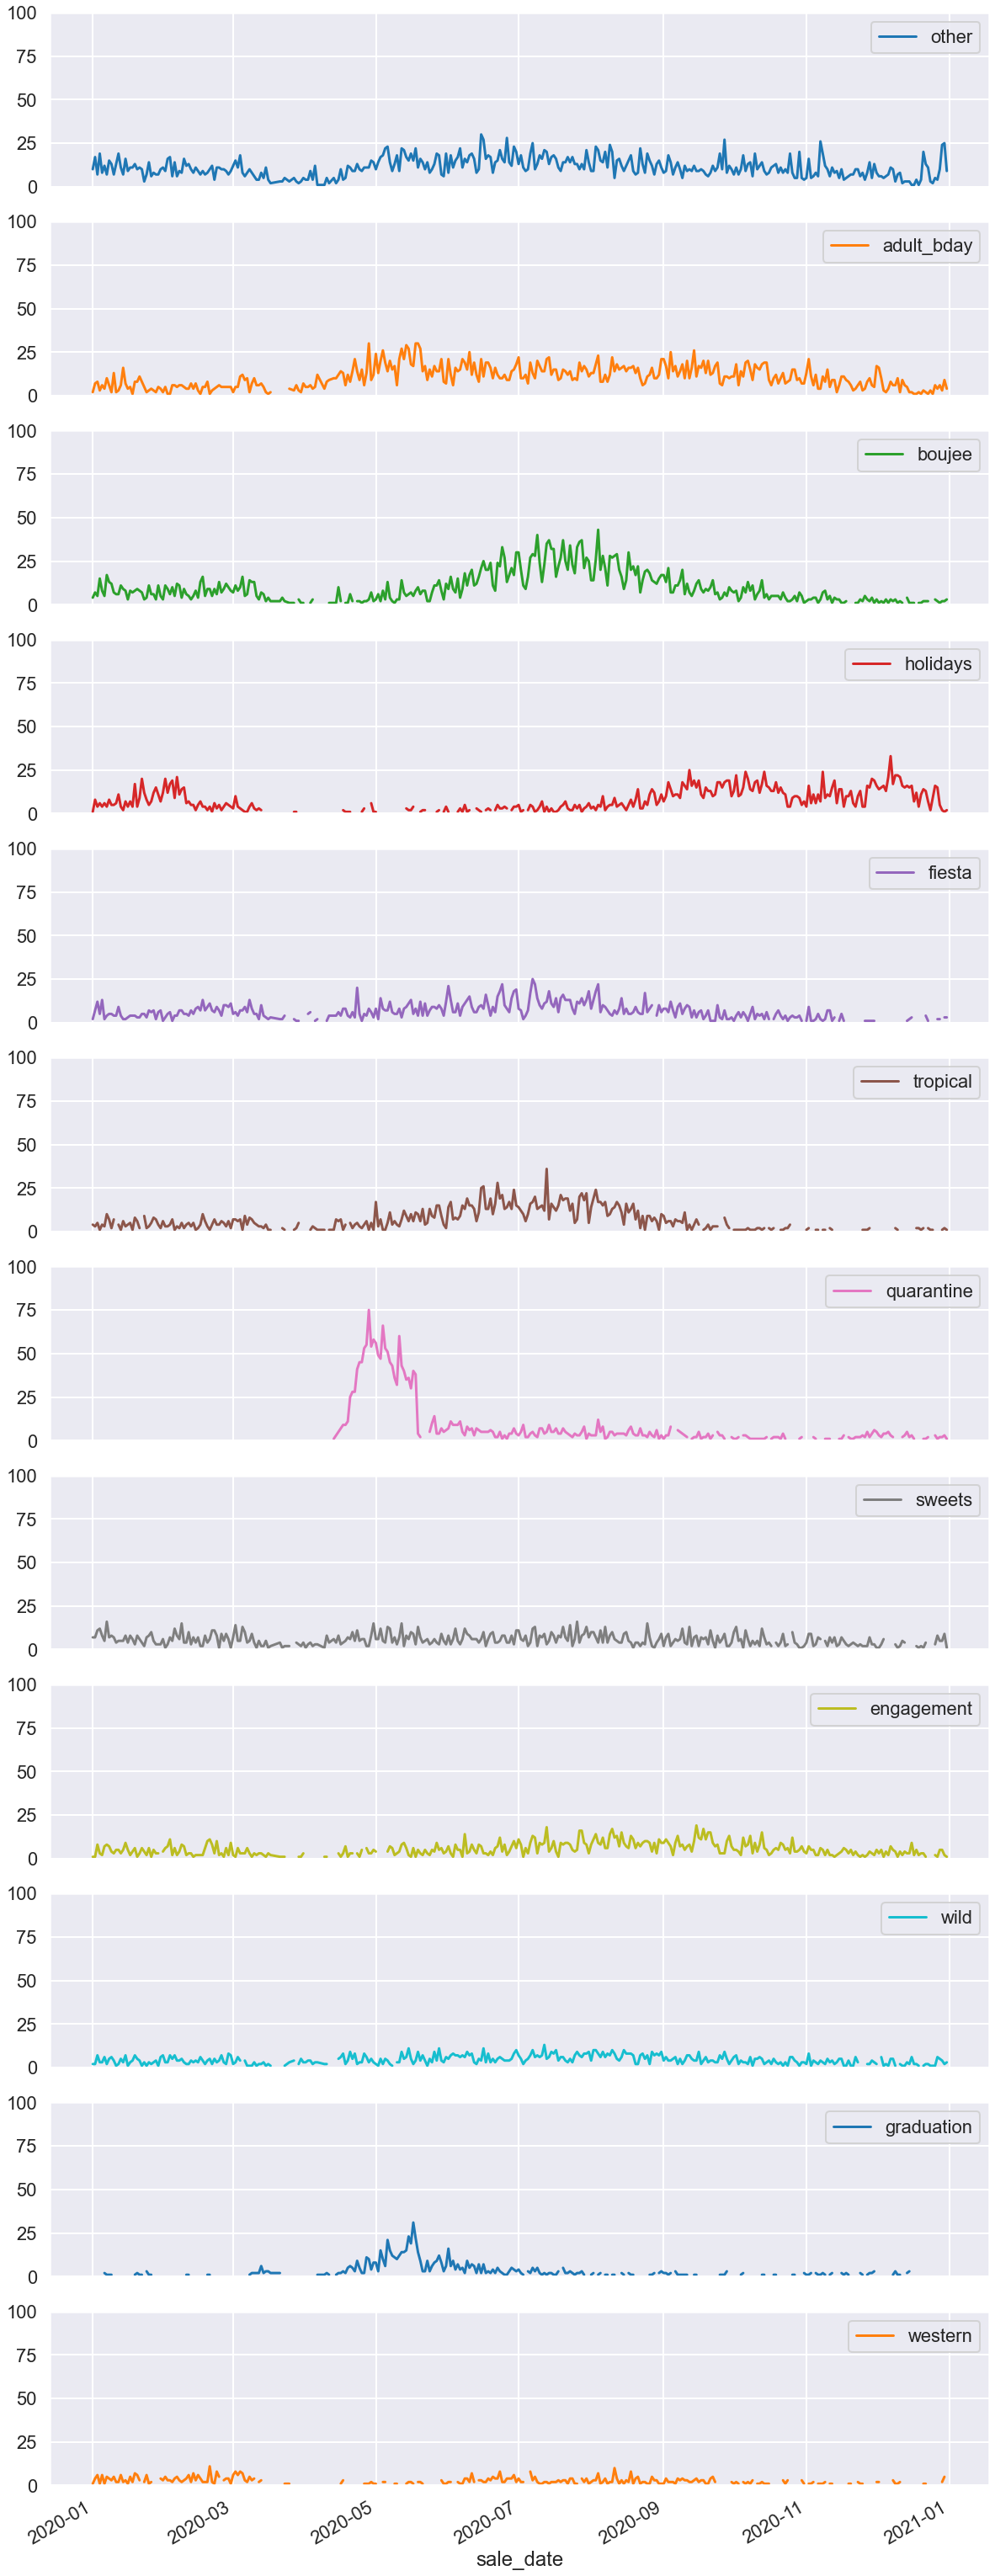

In [59]:
 # Create a new DataFrame and store values by category in columns 
data_category = pd.DataFrame()

for category in top_tags.index:
    data_category[category] = combined[combined.main_tag == category].groupby('sale_date')['quantity'].sum()

# Plot the category groups as subplots
data_category.plot(figsize = (20,60), subplots=True, legend=True, ylim=(0,100));

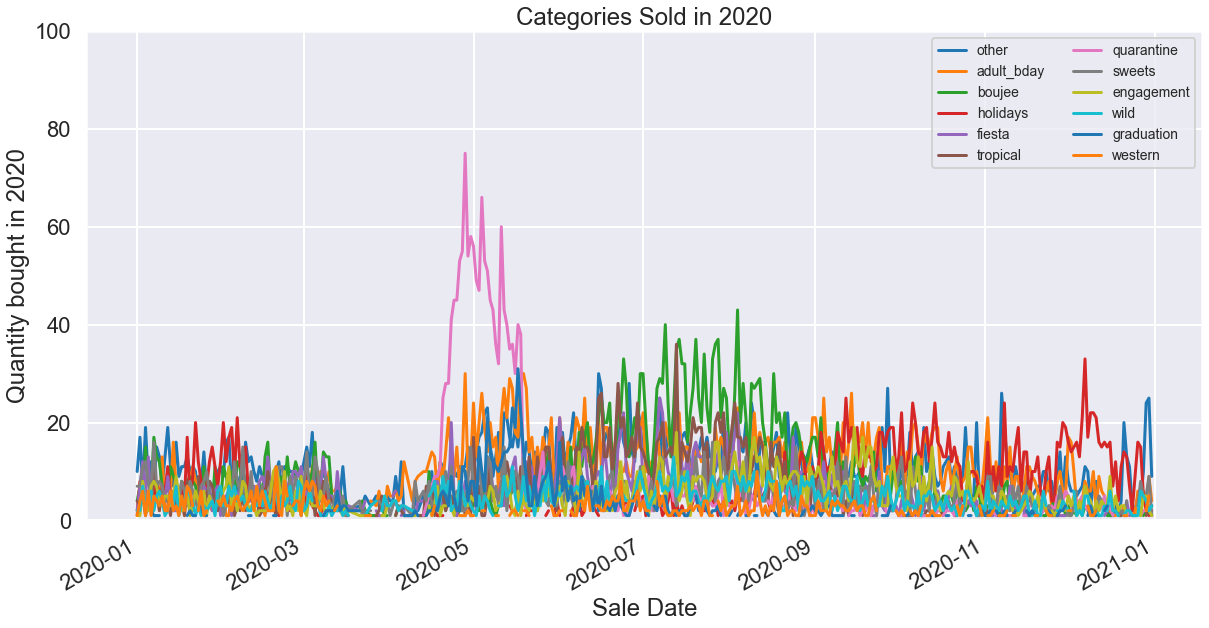

In [60]:
# Plot all categories on the same graph
data_category.plot(figsize = (20,10), subplots=False, legend=True, ylim=(0,100)).legend(prop={"size":14},
                                                                                        ncol=2, loc='best')
plt.title('Categories Sold in 2020')
plt.xlabel('Sale Date')
plt.ylabel('Quantity bought in 2020')
fig.tight_layout();

In [61]:
# reset styles of visualizations
sns.set_style('darkgrid')
sns.set_context('poster')

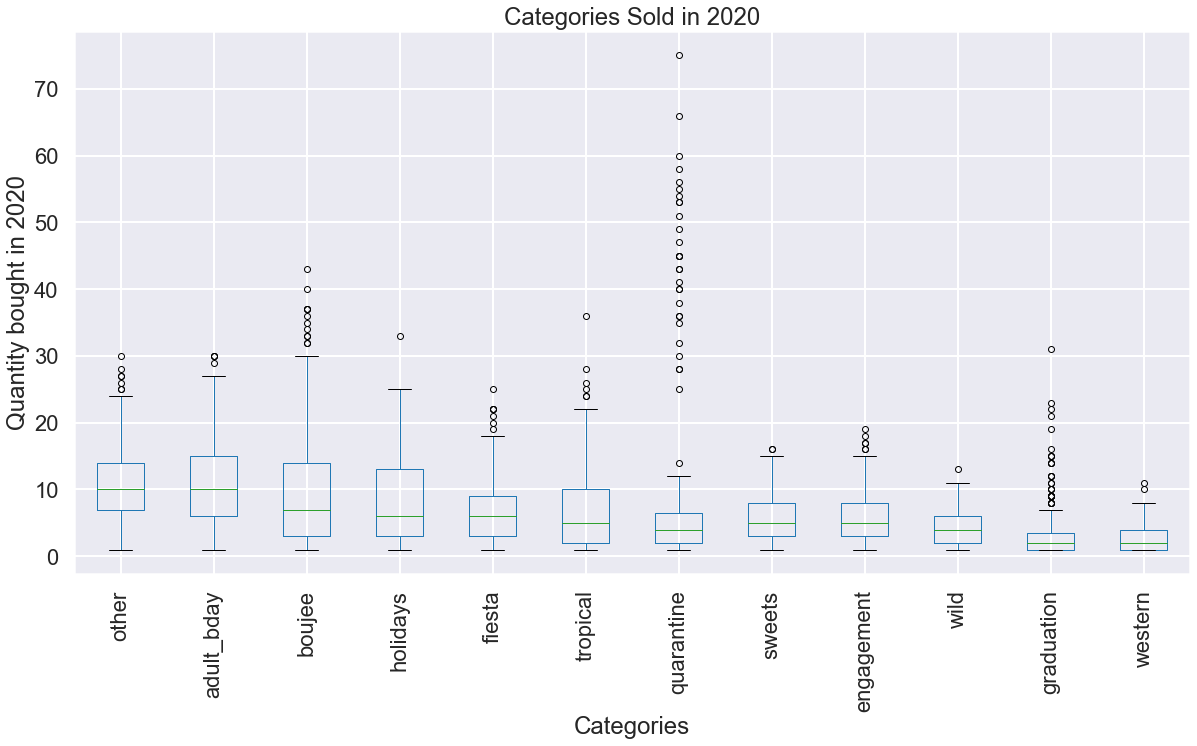

In [62]:
# Generate a box and whiskers plot for states
data_category.boxplot(figsize = (20,10), rot=90)
plt.title('Categories Sold in 2020')
plt.xlabel('Categories')
plt.ylabel('Quantity bought in 2020')
fig.tight_layout();